In [223]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv") #series1
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv") #series2
airlines_passengers = pd.read_csv("international-airline-passengers.csv") #series3
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv") #series4
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv") #series5
female_births = pd.read_csv("daily-total-female-births-in-cal.csv") #series6

# Отображение графика

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

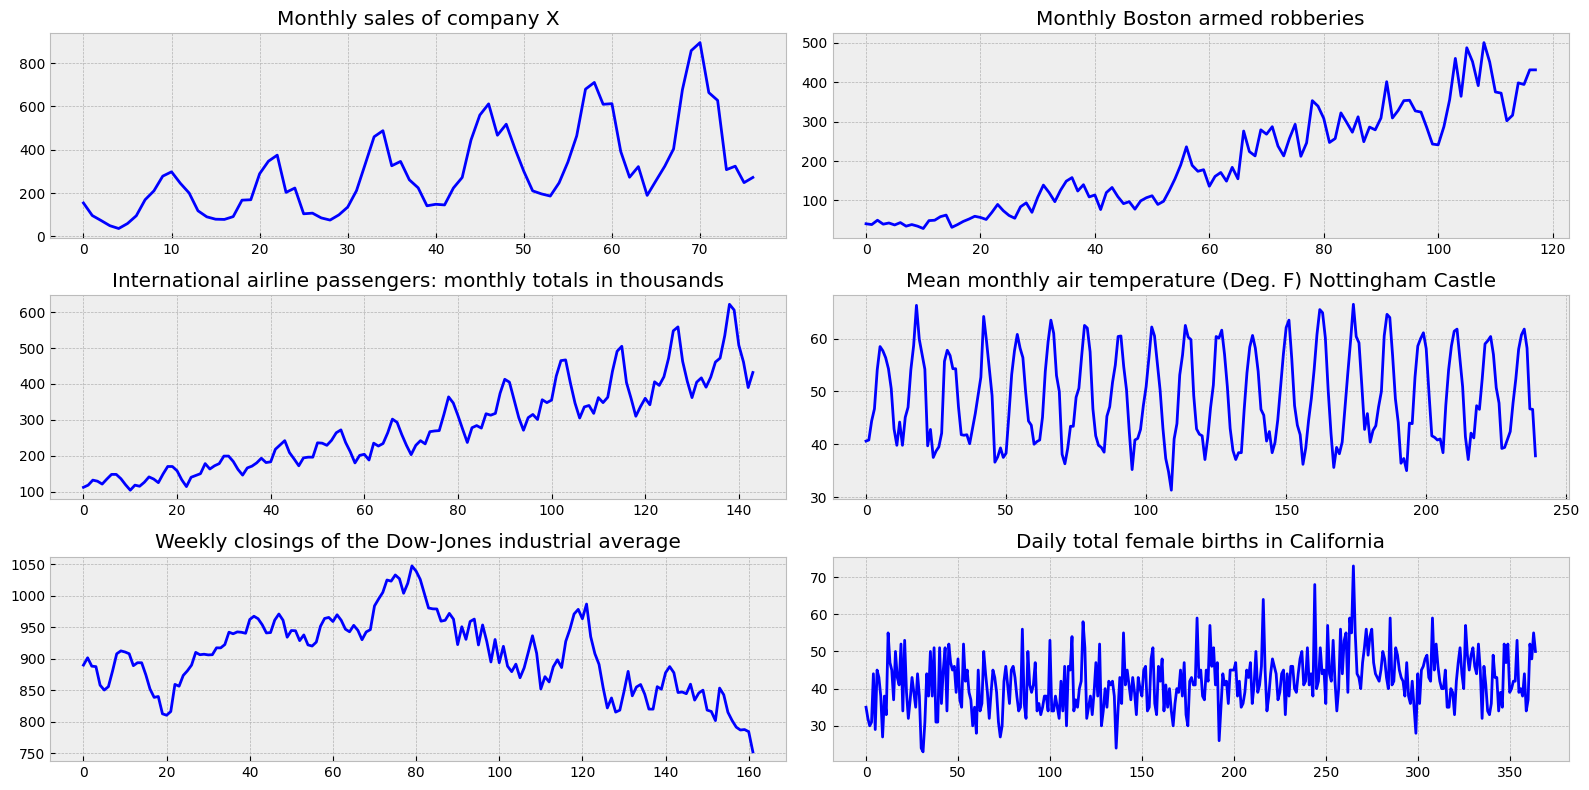

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

**Проверям данные с помощью теста Dickey-Fuller**

In [6]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries, dfname):
    print(dfname)
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
for k,v in all_series.items():
  test_stationarity(all_series[k], k)
  print()

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critic

На основе визуального анализа и данных теста Дики-Фуллера можно сделать вывод что временной рад "Daily total female births in California" является стационарным.

Для временного ряда "Mean monthly air temperature (Deg. F) Nottingham Castle" значения p-value ниже 0.05 и визуально этот ряд похож на стационарный, но кажется что в нем есть цикличность, постараемся получить более стационарный временной ряд

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

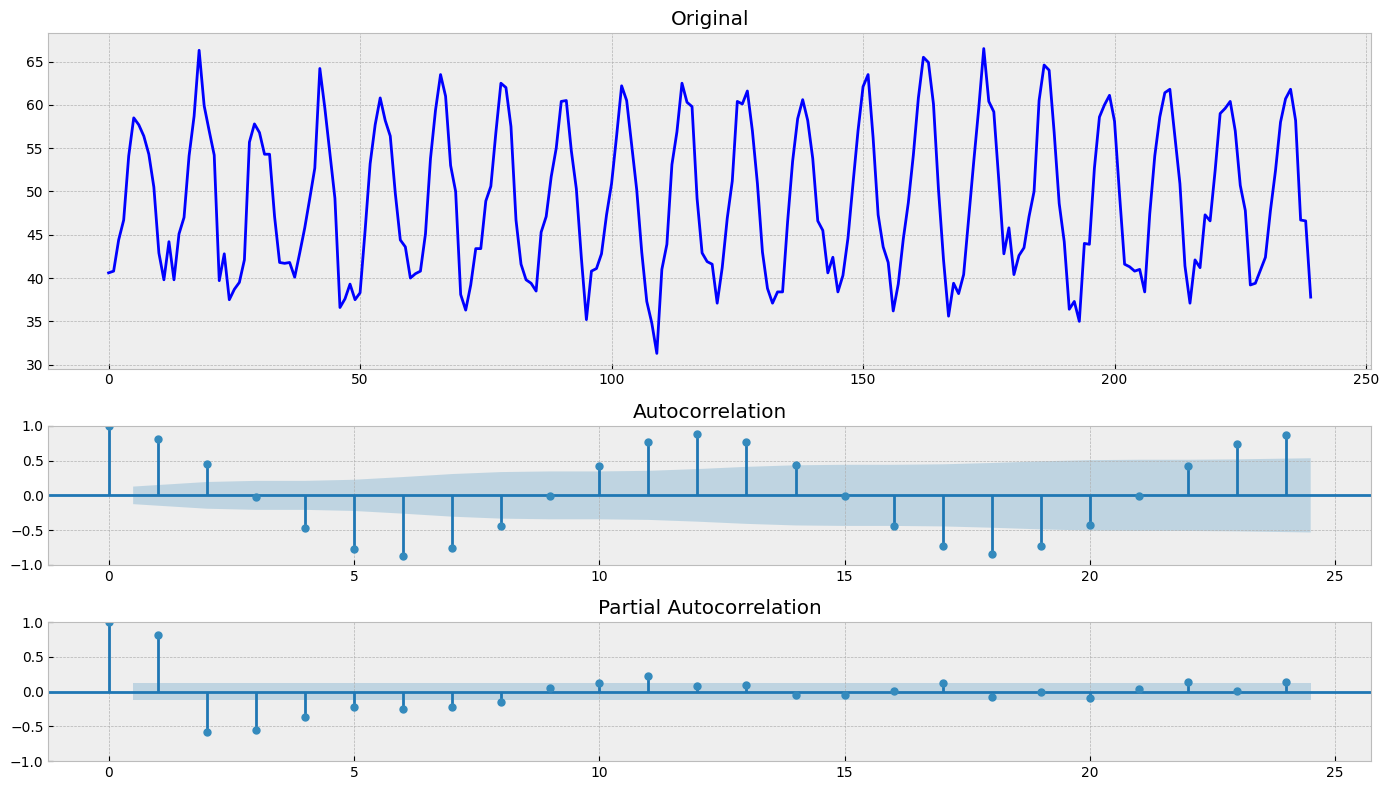

In [145]:
series4 = all_series['Mean monthly air temperature (Deg. F) Nottingham Castle']
# рассмотрим данные поближе
tsplot(series4)

In [147]:
# на графике колебания очень похожи на тренды и было решено поробовать такой вариант
series4 = np.diff(series4, 2)

In [148]:
# не уверен что это правильное решение
test_stationarity(series4, 'Mean monthly air temperature (Deg. F) Nottingham Castle')

Mean monthly air temperature (Deg. F) Nottingham Castle
Results of Dickey-Fuller Test:
Test Statistic                -1.041098e+01
p-value                        1.804502e-18
#Lags Used                     1.500000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


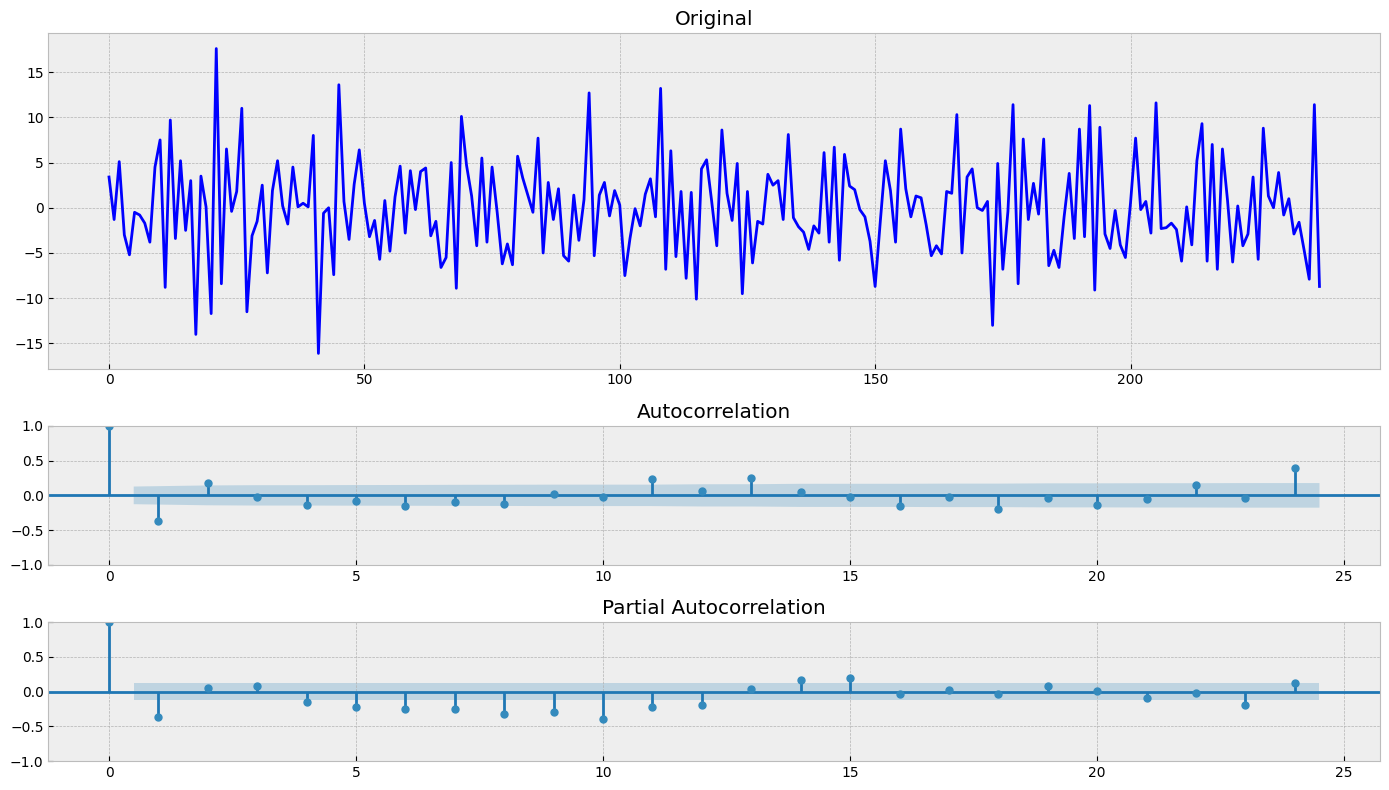

In [149]:
tsplot(series4)

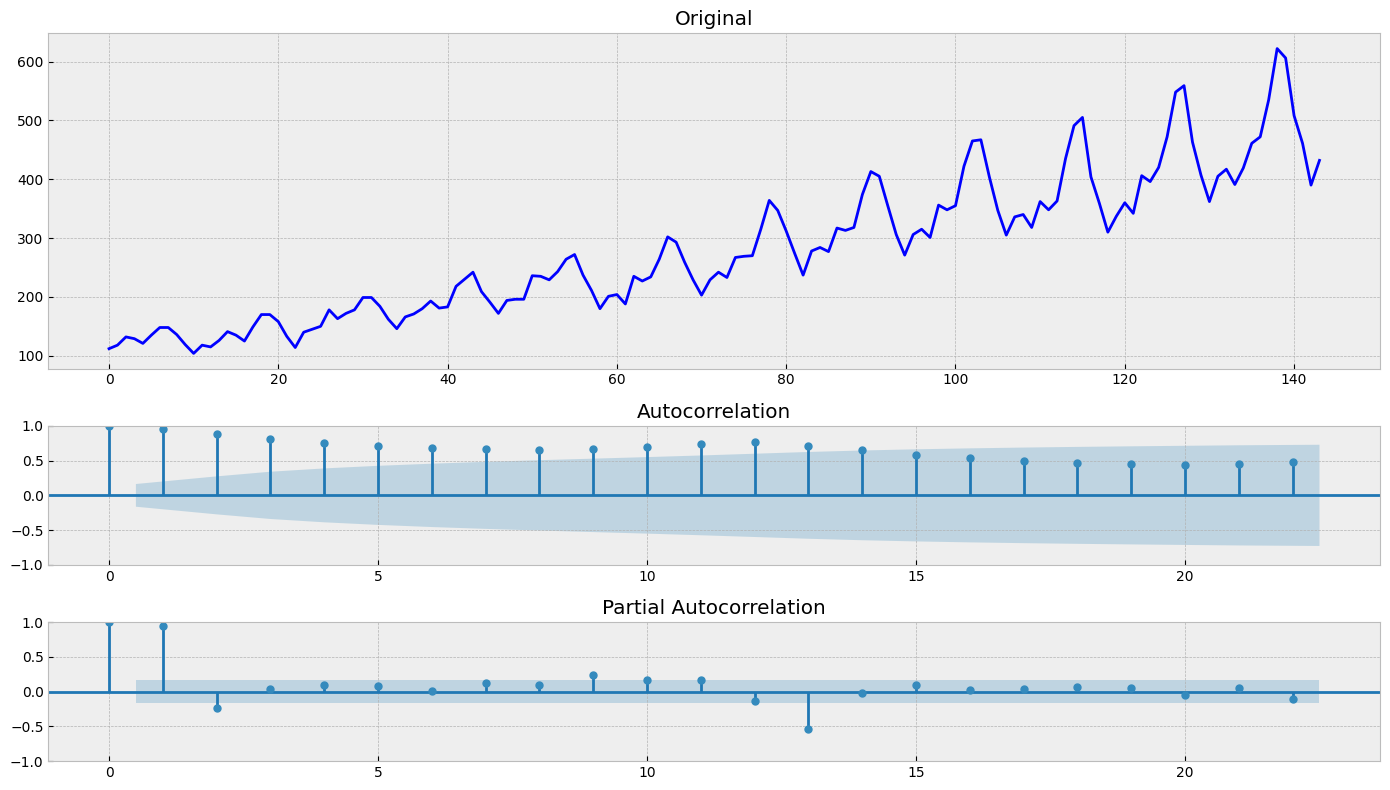

In [172]:
# едем дальше, следующий вариант
series3 = all_series['International airline passengers: monthly totals in thousands']
tsplot(series3)

In [173]:
# убираем изменения дисперсии
series3 = boxcox(series3, 0)

In [175]:
# убираем тенденцию
series3 = np.diff(series3, 1)

In [165]:
# убираем сезонность
series3 = series3[12:] - series3[:-12]

In [166]:
# готово
test_stationarity(series3, 'International airline passengers: monthly totals in thousands') #0.000249

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


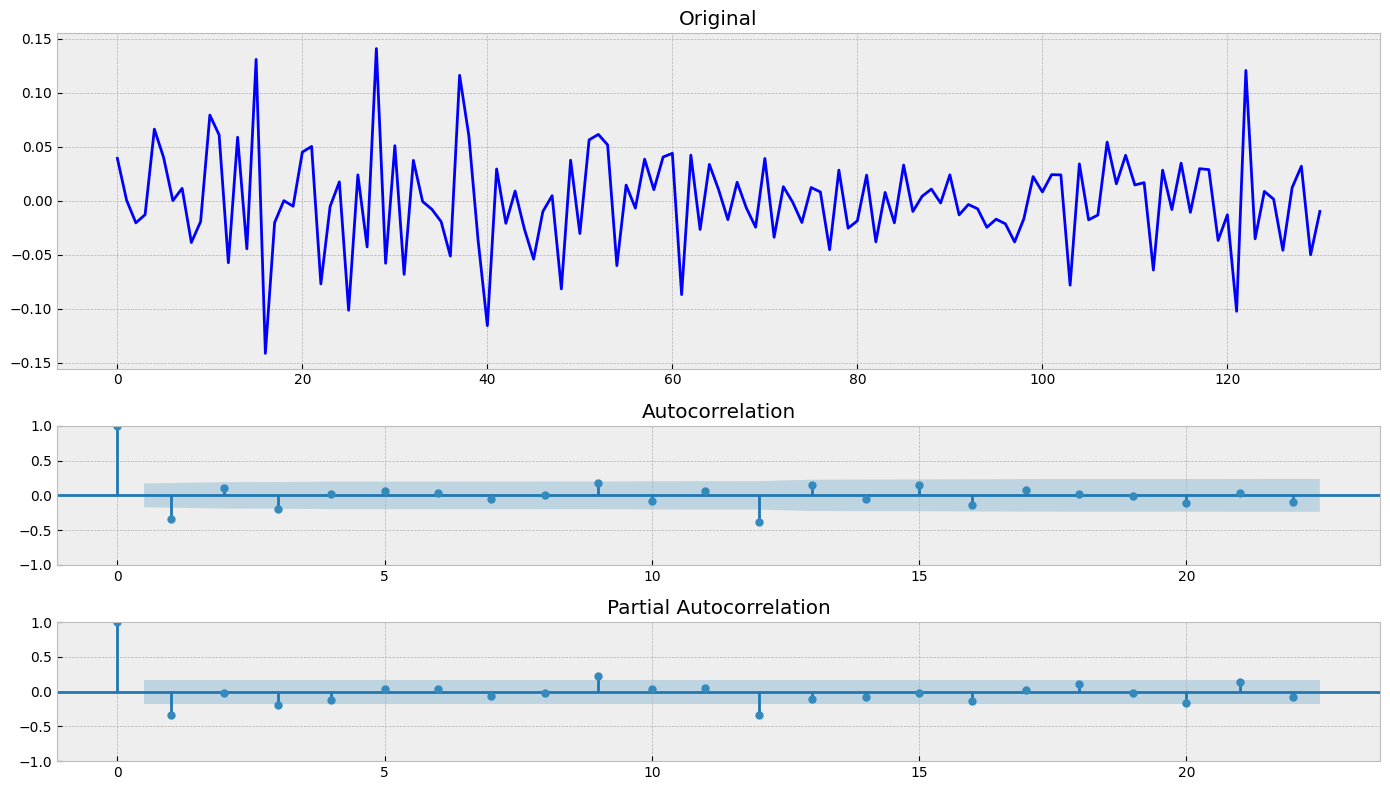

In [167]:
tsplot(series3)

--------------------------------------------------------------------------------

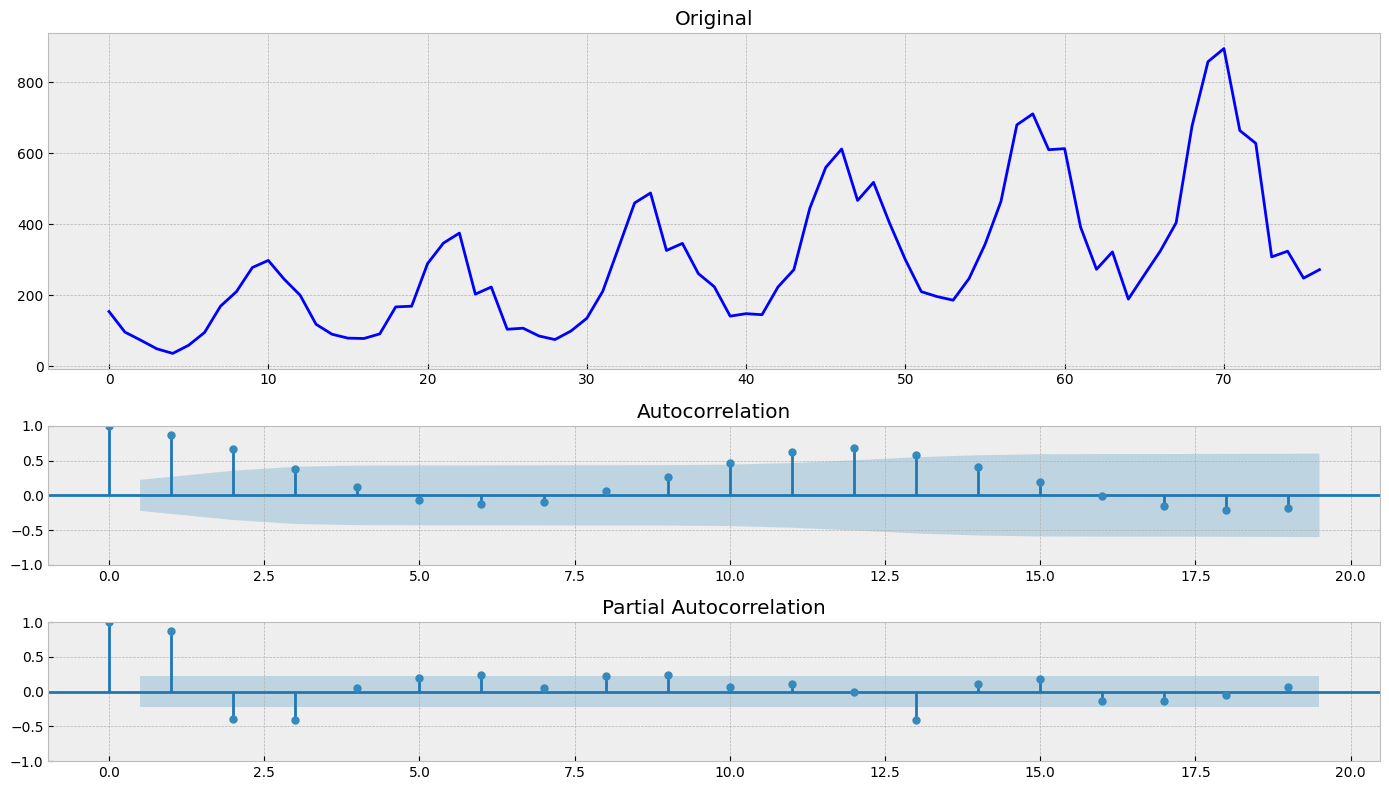

In [177]:
series1 = all_series['Monthly sales of company X']
tsplot(series1)

In [178]:
# если выравнять дисперсию и убрать тренд....
series1 = boxcox(series1, 0)
series1 = np.diff(series1, 1)

In [179]:
# то тест Дики-Фуллера дает приемлемый результат....
test_stationarity(series1, 'Monthly sales of company X')

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


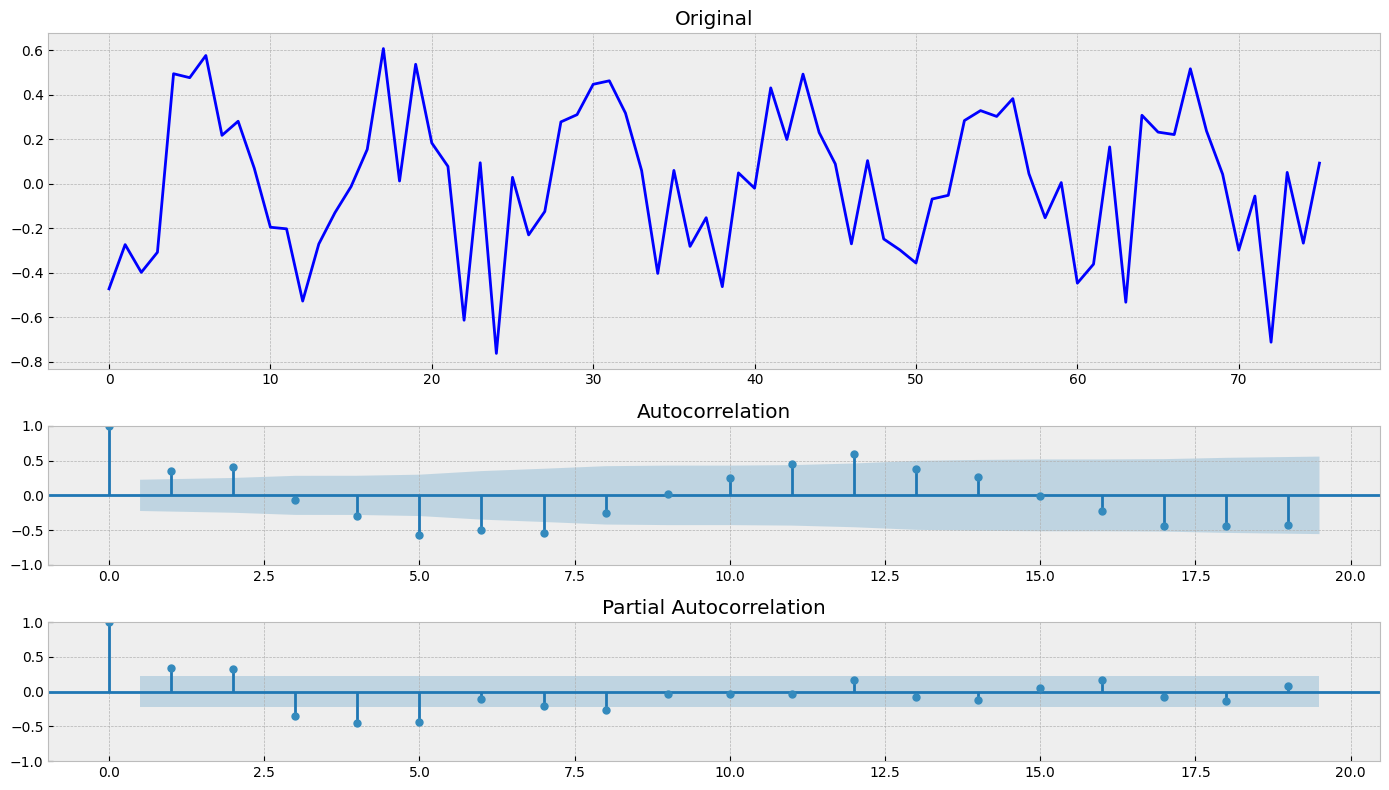

In [180]:
# но временной ряд не похож на шум и как-будто просматривантся сезонность....
tsplot(series1)

In [201]:
# но если попытаться её убрать, тест становится хуже
series11 = series1[12:] - series1[:-12]

In [202]:
test_stationarity(series11, 'Monthly sales of company X')

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


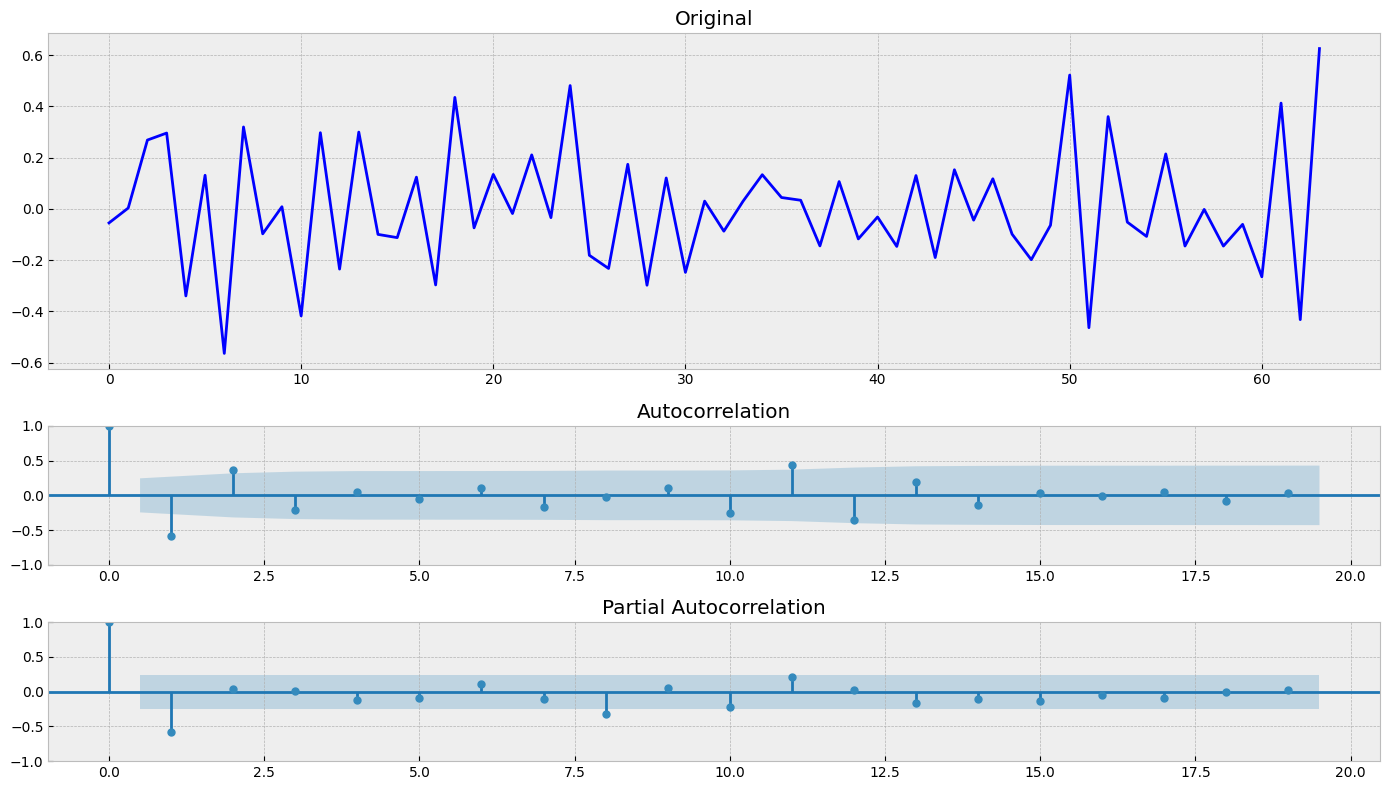

In [203]:
# хотя график выглядит лучше
tsplot(series11)

--------------------------------------------------------------------------------


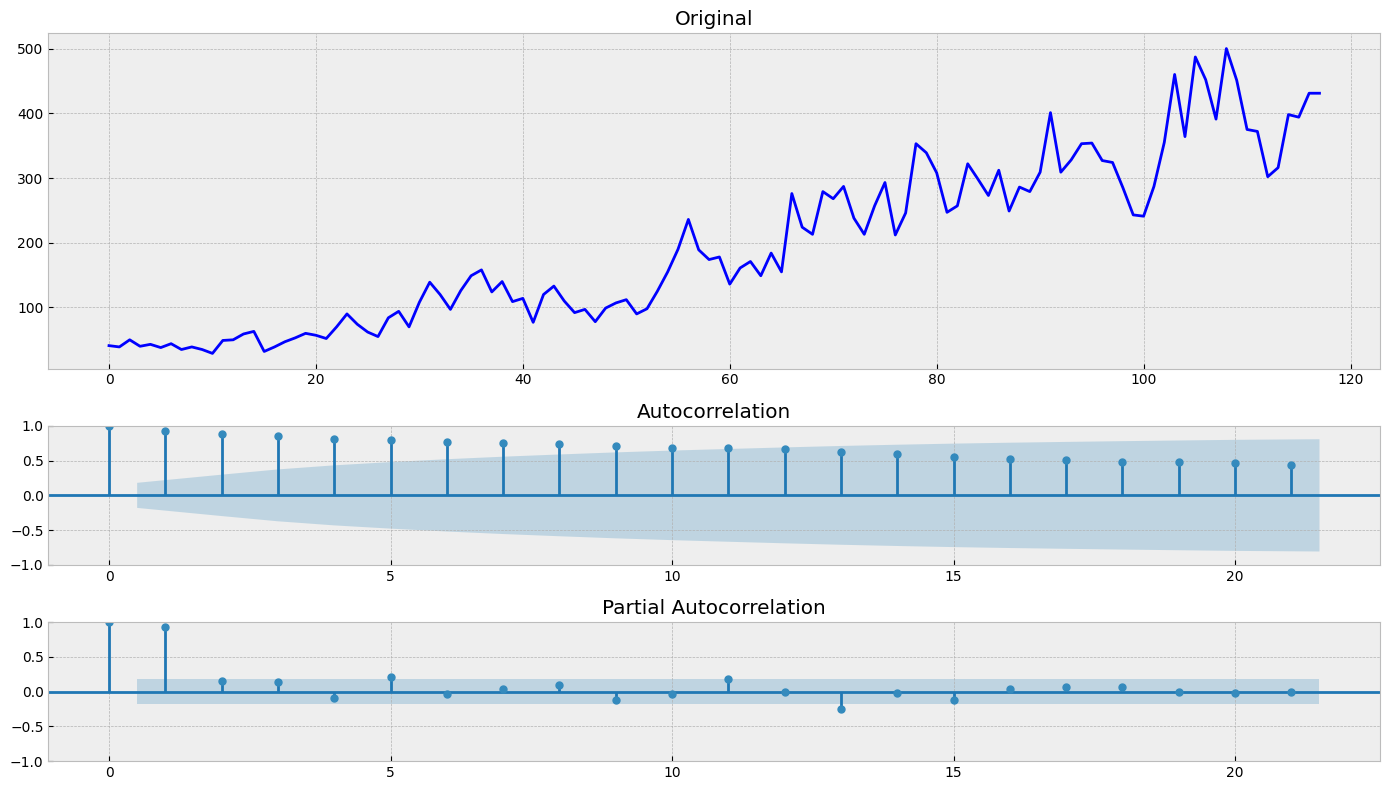

In [209]:
series2 = all_series['Monthly Boston armed robberies']
tsplot(series2)

In [210]:
series2 = boxcox(series2, 0)

In [211]:
series2 = np.diff(series2, 1)

In [212]:
test_stationarity(series2, 'Monthly Boston armed robberies')

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


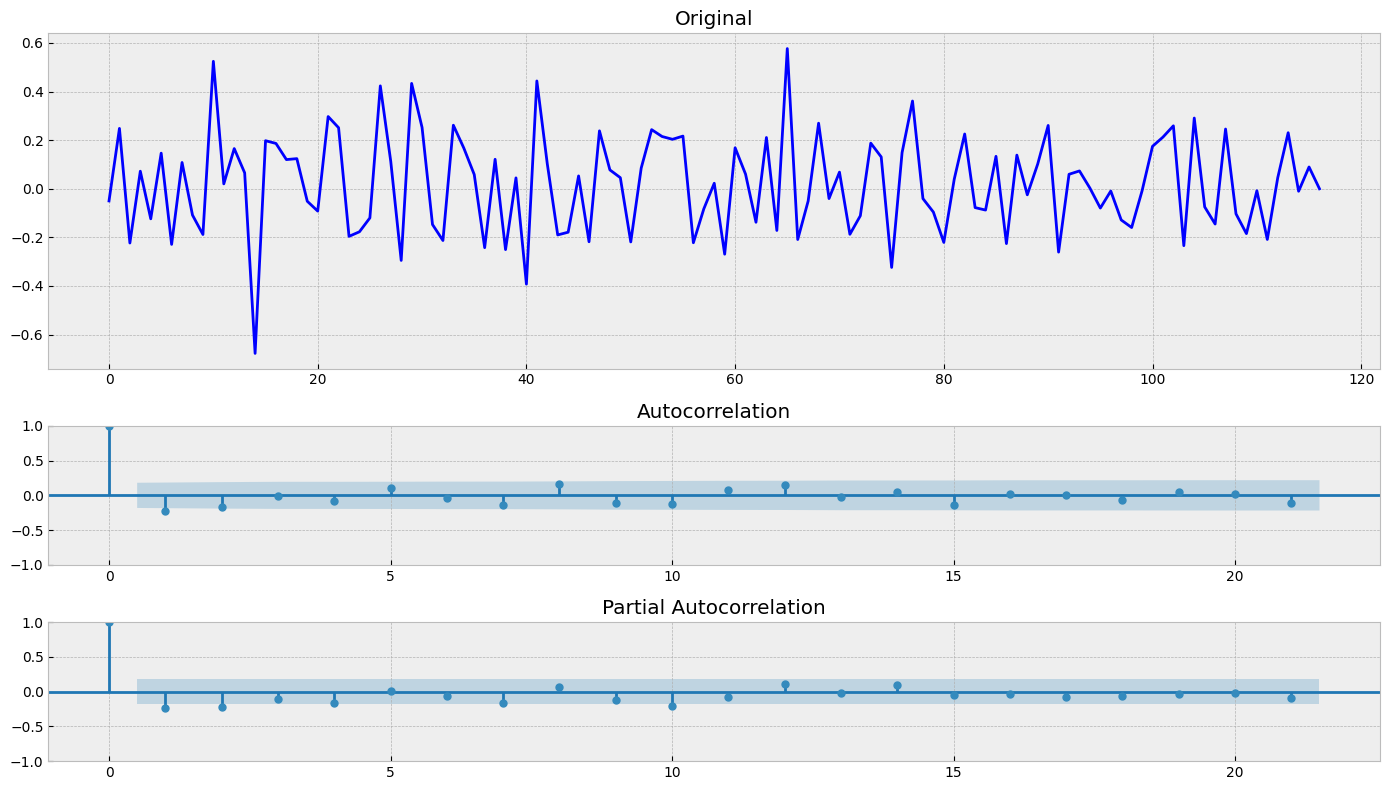

In [213]:
tsplot(series2)

----------------------------------------------------------------------------

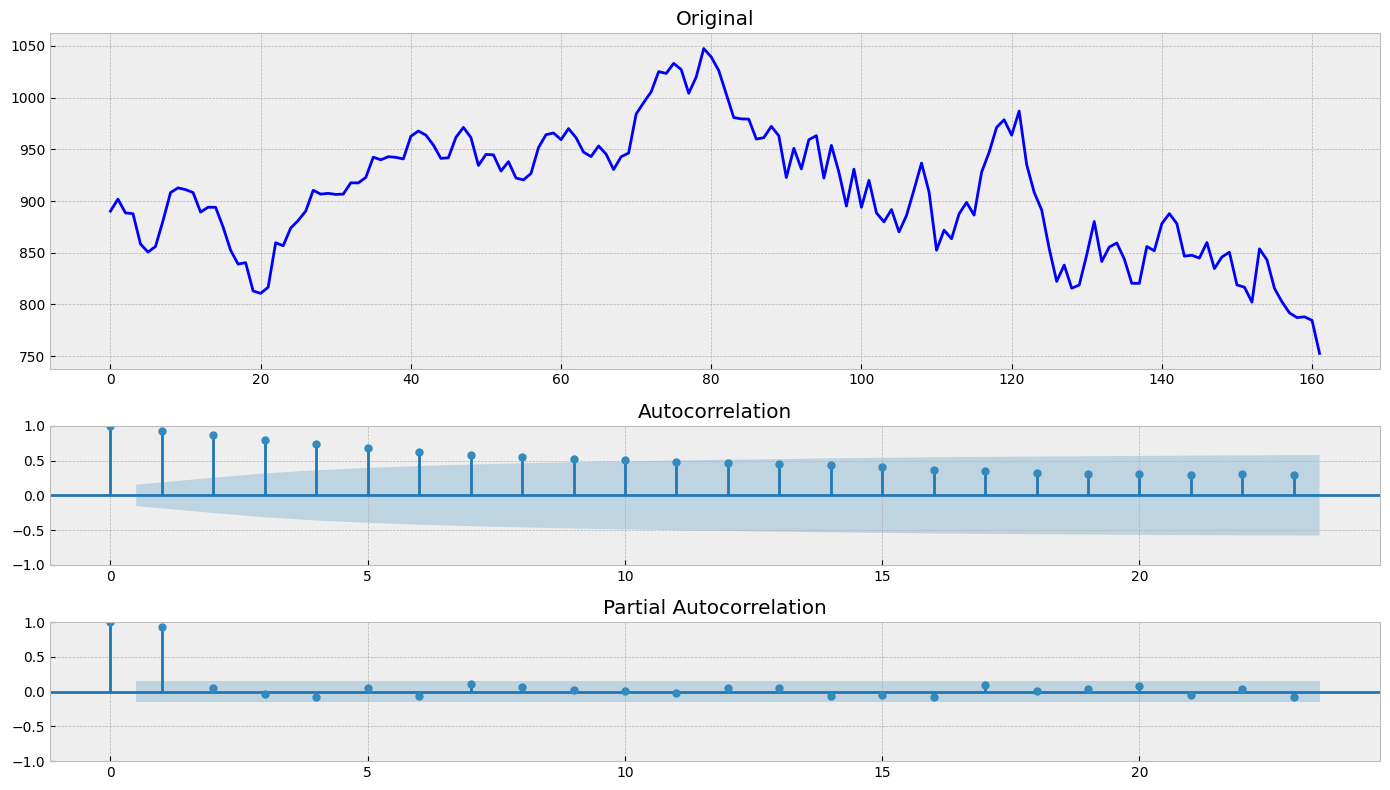

In [219]:
series5 = all_series['Weekly closings of the Dow-Jones industrial average']
tsplot(series5)

In [220]:
series5 = np.diff(series5, 1)

Weekly closings of the Dow-Jones industrial average
Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64



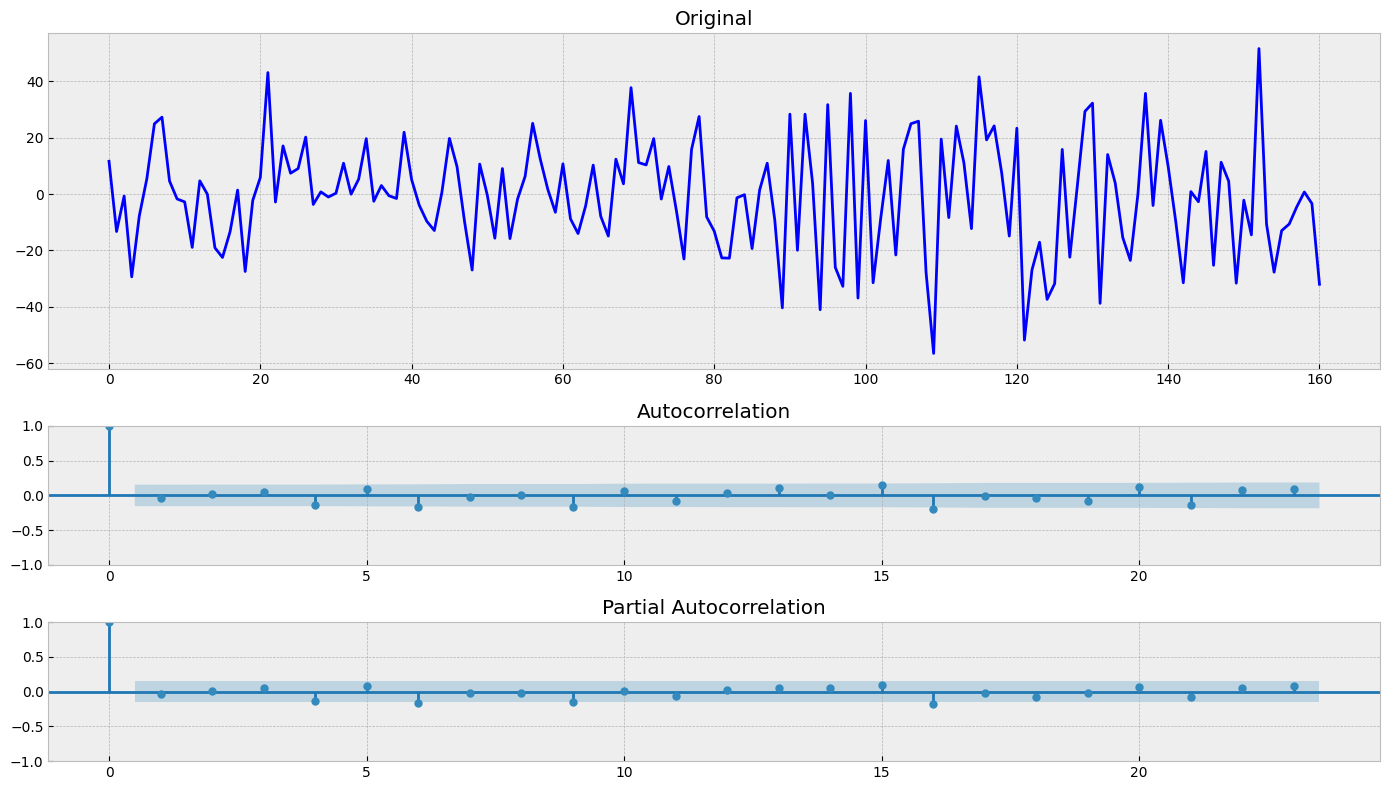

In [222]:
test_stationarity(series5, 'Weekly closings of the Dow-Jones industrial average')
print()
tsplot(series5)